# **DataKit Challenge: Producers Direct**

## **Challenge 2: Seasonality (Kenya): Part I**

By Conrad Kleykamp

Table of Contents:
- [Executive Summary](#1)
- [Set Up](#2)
- [Data Preprocessing](#3)
    - [Filtering: Kenya & English](#3.1)
    - [Filtering: Nulls & Duplicates](#3.2)
- [Temporal Feature Engineering](#4)
    - [Basic Temporal Features](#4.1)
    - [Standard Meteorological Seasons](#4.2)
    - [Kenya Agricultural Seasons](#4.3) 
- [Seasonal Statistics](#5)
- [Visualizations](#6)
- [Exporting Cleaned/Preprocessed Data](#7)

## **1) Executive Summary**

---

### **Overview**

Relevant Challenge:

- **Challenge 2: Seasonality**

The overarching goal of this project is to identify seasonal patterns (based on temporal data) that may influence the types of questions that farmers ask. Predictive insights may assist farmers by preemptively determining their needs prior to significant weather/climate/seasonal challenges. 

### **Current Project Phase: Basic Seasonal Analysis (Kenya)**
In my first [submission](https://github.com/datakind/datakit-smallholder-farmers-fall-2025/blob/main/Challenge%202_Seasonality/ConradKleykamp/Conrad%20Kleykamp%20Initial%20EDA.ipynb), I identified **Kenya** as a suitable candidate for seasonal analysis, as it had a large volume of English questions and had a significant temporal range, i.e. 9.76M questions, 77% English, 4.6 years (2017-2022). 

In this phase, the original data was filtered to include only questions from Kenya that were in English. Following this, new temporal features, such as meteorological and agricultural seasons were created. The resulting dataframe was stored and downloaded for future analysis.

This phase culminated with an analysis of the distributions of questions across seasons types, months, and years.

The next phase of this project will drill down on word categories/topics and attempt to uncover seasonal patterns there (see Next Steps).

### **Methodology**

- **Formatting**: Datetime fields (question_sent) were parsed with ISO8601 formatting to handle mixed precision timestamps. 
- **Filtering**: Isolated 9.76M Kenya questions from 20.3M total questions across 4 countries, then filtered to 7.5M English questions (77% of Kenya total, 37% of grand total).
- **Cleaning**: Found 0% null values in question_content. Found 5.8M duplicate question_id, but discovered that duplicates were a result of multiple question-response pairs. To maintain a more robust data pool, duplicates were not dropped.
- **Temporal/Seasonal Feature Engineering**: Added temporal variables (e.g. year, month, quarter, day of year) and boolean indicators for agricultural seasons. Generated standard meteorological seasons (Southern Hemisphere) and Kenya-specific agricultural seasons aligned with climate patterns (provided by DataKind):
    - Long Rains (Mar-May): Main planting season
    - Short Rains (Oct-Dec): Secondary planting season
    - Harvest 1 (Jun-Aug): Primary harvest period
    - Harvest 2 (Jan-Feb): Secondary harvest period
    - Transition (Sep): Between-season period
- **Visualization**: Created four-panel temporal distribution analysis showing question volume over time, monthly aggregations, standard seasonal distribution, and Kenya agricultural seasonal distribution.

### **Key Findings**
- **Question Volume Over Time**:
    - Peak period from late 2018 to early 2019 with monthly volumes >500,000; Suggests high engagement with the WeFarm platform or other significant circumstances
    - Gradual decrease in volume from 2020 onward; Suggests less engagement with the platform or other external factors requiring investigation
- **Question Volume by Month / Seasons (All Years Combined)**:
    - Consistent high volume (>690K) from August to December; Indicating more questions/platform usage during the tail end of the first harvest season (August) to the tail end of the short rains/secondary planting season (December)
    - Highest volumes during August (921K) and November (942K)
    - Lowest volumes from January (355K) to February (335K); Indicating fewer questions during the second harvest season
    - Higher total volume for the short rains/secondary planting season (2.5M), compared to the long rains/primary planting season (1.7M).

### **Next Steps**

- Category-level analysis to identify which agricultural topics (e.g., planting, pest, disease, harvest) drive seasonal peaks
- Year-over-year trend analysis to quantify behavioral shifts and validate post-2020 decline causes
- Predictive model development

## **2) Set Up**

---

In [1]:
# Loading in necessary libraries and packages

# Fundamental libraries
import numpy as np 
import pandas as pd 

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'white', palette = 'Set2')
pal = sns.color_palette('Set2')

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# Loading in the data (parquet)
print("Loading data...")
df = pd.read_parquet('/kaggle/input/datakit-nov/producersdirectdata.parquet')
print(f"Loaded {len(df):,} rows\n")

Loading data...
Loaded 20,304,843 rows



In [3]:
# Parsing dates with ISO8601 format
print("Parsing dates...")
df['question_sent'] = pd.to_datetime(df['question_sent'], format='ISO8601')
print(f"Dates parsed: {df['question_sent'].notna().sum():,} valid dates")
print(f"Null dates: {df['question_sent'].isna().sum():,}")

Parsing dates...
Dates parsed: 20,304,843 valid dates
Null dates: 0


## **3) Data Preprocessing**

---

### **3.1) Filtering: Kenya + English**

In [4]:
# Filtering to Kenya questions
# Storing as df_kenya
df_kenya = df[df['question_user_country_code'] == 'ke'].copy()
print(f"Kenya questions: {len(df_kenya):,} ({len(df_kenya)/len(df)*100:.1f}% of total questions)")

Kenya questions: 9,758,607 (48.1% of total questions)


In [5]:
# Filtering to English questions
# Storing as df_kenya_eng
df_kenya_eng = df_kenya[df_kenya['question_language'] == 'eng'].copy()
print(f"Kenya English questions: {len(df_kenya_eng):,} ({len(df_kenya_eng)/len(df_kenya)*100:.1f}% of Kenya questions)")

Kenya English questions: 7,511,473 (77.0% of Kenya questions)


In [6]:
# Viewing summary of filtering
print("FILTERING SUMMARY:")
print(f"  Original dataset:     {len(df):,}")
print(f"  Kenya only:           {len(df_kenya):,} (-{len(df)-len(df_kenya):,})")
print(f"  Kenya + English:      {len(df_kenya_eng):,} (-{len(df_kenya)-len(df_kenya_eng):,})")
print(f"  Final retention:      {len(df_kenya_eng)/len(df)*100:.2f}%")

FILTERING SUMMARY:
  Original dataset:     20,304,843
  Kenya only:           9,758,607 (-10,546,236)
  Kenya + English:      7,511,473 (-2,247,134)
  Final retention:      36.99%


### **3.2) Filtering: Nulls and Duplicates**

In [7]:
# Checking for nulls in key columns
key_columns = ['question_id', 'question_content', 'question_sent', 'question_topic']
print("\nNull values in key columns:")
for col in key_columns:
    if col in df_kenya_eng.columns:
        null_count = df_kenya_eng[col].isnull().sum()
        null_pct = (null_count / len(df_kenya_eng) * 100)
        print(f"  {col:25s}: {null_count:,} ({null_pct:.2f}%)")


Null values in key columns:
  question_id              : 0 (0.00%)
  question_content         : 0 (0.00%)
  question_sent            : 0 (0.00%)
  question_topic           : 825,179 (10.99%)


In [8]:
# Checking for duplicate question ids
duplicates = df_kenya_eng['question_id'].duplicated().sum()
print(f"  Duplicate question_ids: {duplicates:,}")

  Duplicate question_ids: 5,846,471


**Note** that a separate analysis (not shown here to streamline the notebook) found that the large number of duplicate question_ids is due to multiple question-response pairs, i.e. many questions received multiple responses, which in turn created duplicate question_ids. In order to have a more robust data pool, I have opted to forgo removing these duplicate question_ids. 

In [9]:
# Creating cleaned copy of the data
df_kenya_clean = df_kenya_eng.copy()

## **4) Temporal Feature Engineering**

### **4.1) Basic Temporal Features**

In [10]:
# Creating basic temporal features
df_kenya_clean['year'] = df_kenya_clean['question_sent'].dt.year
df_kenya_clean['month'] = df_kenya_clean['question_sent'].dt.month
df_kenya_clean['month_name'] = df_kenya_clean['question_sent'].dt.month_name()
df_kenya_clean['quarter'] = df_kenya_clean['question_sent'].dt.quarter
df_kenya_clean['day_of_year'] = df_kenya_clean['question_sent'].dt.dayofyear
df_kenya_clean['week_of_year'] = df_kenya_clean['question_sent'].dt.isocalendar().week

### **4.2) Standard Meteorological Seasons**

In [11]:
# Defining and assigning standard meteorological seasons
# (Southern Hemisphere)
def assign_standard_season(month):
    """
    Assigning standard meteorological seasons (Southern Hemisphere)
    Spring: September-November
    Summer: December-February
    Fall: March-May
    Winter: June-August
    """
    if month in [9, 10, 11]:
        return 'Spring'
    elif month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Fall'
    elif month in [6, 7, 8]:
        return 'Winter'

# Applying function
df_kenya_clean['standard_season'] = df_kenya_clean['month'].apply(assign_standard_season)

### **4.2) Kenya Agricultural Seasons**

In [12]:
# Defining and assigning Kenyan agricultural seasons
def assign_kenya_season(month):
    """
    Assigning agricultural seasons based on Kenya's climate patterns
    Long rains: March-May (main planting)
    Short rains: October-December (secondary planting)
    Harvest 1: June-August
    Harvest 2: January-February
    """
    if month in [3, 4, 5]:
        return 'Long Rains (Mar-May)'
    elif month in [10, 11, 12]:
        return 'Short Rains (Oct-Dec)'
    elif month in [6, 7, 8]:
        return 'Harvest 1 (Jun-Aug)'
    elif month in [1, 2]:
        return 'Harvest 2 (Jan-Feb)'
    else:
        return 'Transition (Sep)'

# Applying function
df_kenya_clean['kenya_season'] = df_kenya_clean['month'].apply(assign_kenya_season)

In [13]:
# Creating season indicators

# Rainy season indicator
df_kenya_clean['is_rainy_season'] = df_kenya_clean['month'].isin([3, 4, 5, 10, 11, 12])

# Planting season indicator
df_kenya_clean['is_planting_season'] = df_kenya_clean['month'].isin([3, 4, 5, 10, 11, 12])

# Harvest season indicator
df_kenya_clean['is_harvest_season'] = df_kenya_clean['month'].isin([1, 2, 6, 7, 8])

## **5) Seasonal Statistics**

In [14]:
# Questions by year
print("\nQuestions by year:")
year_counts = df_kenya_clean['year'].value_counts().sort_index()
for year, count in year_counts.items():
    print(f"  {year}: {count:,}")

# Questions by standard meteorological season
print("\nQuestions by standard meteorological season:")
standard_season_counts = df_kenya_clean['standard_season'].value_counts()
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
for season in season_order:
    if season in standard_season_counts.index:
        count = standard_season_counts[season]
        pct = count / len(df_kenya_clean) * 100
        print(f"  {season:10s}: {count:,} ({pct:.1f}%)")

# Questions by Kenyan argricultural season
print("\nQuestions by Kenyan agricultural season:")
kenya_season_counts = df_kenya_clean['kenya_season'].value_counts()
for season, count in kenya_season_counts.items():
    pct = count / len(df_kenya_clean) * 100
    print(f"  {season:30s}: {count:,} ({pct:.1f}%)")

# Questions by month
print("\nQuestions by month:")
month_counts = df_kenya_clean.groupby('month').size()
for month, count in month_counts.items():
    month_name = df_kenya_clean[df_kenya_clean['month']==month]['month_name'].iloc[0]
    pct = count / len(df_kenya_clean) * 100
    print(f"  {month:2d} ({month_name:9s}): {count:,} ({pct:.1f}%)")


Questions by year:
  2017: 48,133
  2018: 3,596,226
  2019: 2,096,698
  2020: 1,299,626
  2021: 454,973
  2022: 15,817

Questions by standard meteorological season:
  Spring    : 2,442,351 (32.5%)
  Summer    : 1,526,203 (20.3%)
  Fall      : 1,738,385 (23.1%)
  Winter    : 1,804,534 (24.0%)

Questions by Kenyan agricultural season:
  Short Rains (Oct-Dec)         : 2,468,350 (32.9%)
  Harvest 1 (Jun-Aug)           : 1,804,534 (24.0%)
  Long Rains (Mar-May)          : 1,738,385 (23.1%)
  Transition (Sep)              : 809,305 (10.8%)
  Harvest 2 (Jan-Feb)           : 690,899 (9.2%)

Questions by month:
   1 (January  ): 355,013 (4.7%)
   2 (February ): 335,886 (4.5%)
   3 (March    ): 473,949 (6.3%)
   4 (April    ): 651,859 (8.7%)
   5 (May      ): 612,577 (8.2%)
   6 (June     ): 462,215 (6.2%)
   7 (July     ): 420,763 (5.6%)
   8 (August   ): 921,556 (12.3%)
   9 (September): 809,305 (10.8%)
  10 (October  ): 690,140 (9.2%)
  11 (November ): 942,906 (12.6%)
  12 (December ): 835,

## **6) Visualizations**

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Saved: kenya_temporal_distributions.png


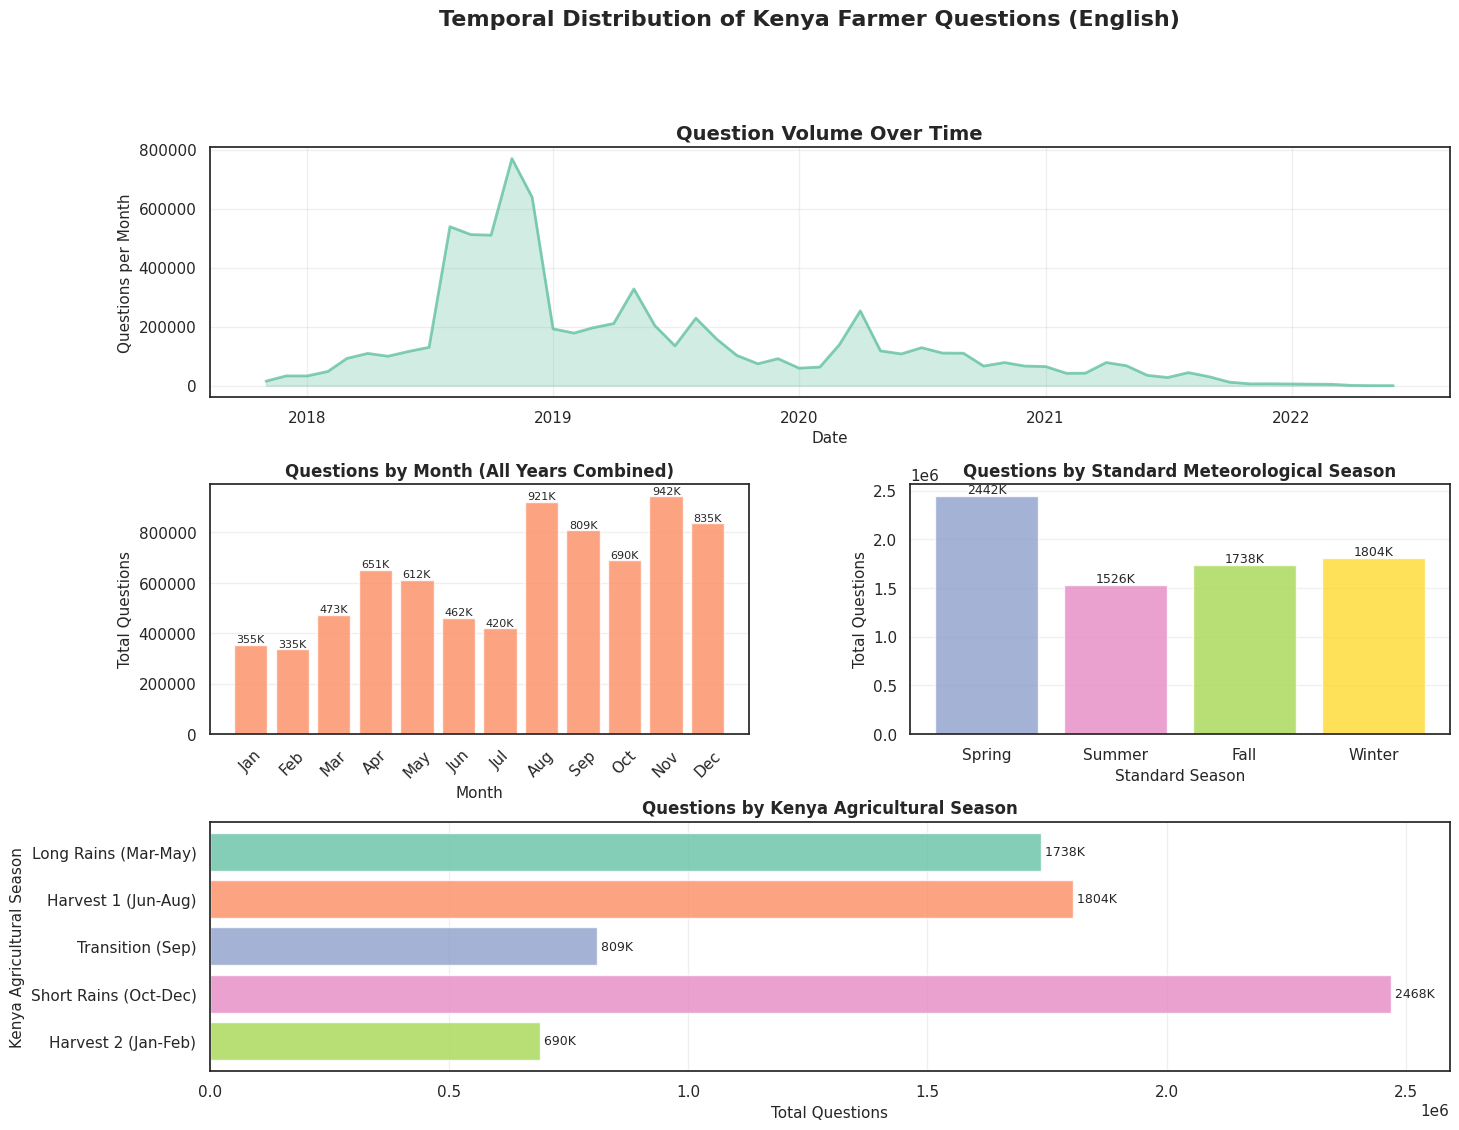

In [17]:
# Creating figure with multiple subplots
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# 1. Questions over time (monthly)
ax1 = fig.add_subplot(gs[0, :])
monthly_counts = df_kenya_clean.groupby(df_kenya_clean['question_sent'].dt.to_period('M')).size()
monthly_counts.index = monthly_counts.index.to_timestamp()

ax1.plot(monthly_counts.index, monthly_counts.values, 
         linewidth=2, color=pal[0], alpha=0.8)
ax1.fill_between(monthly_counts.index, monthly_counts.values, alpha=0.3, color=pal[0])
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Questions per Month', fontsize=11)
ax1.set_title('Question Volume Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Questions by month (aggregated across all years)
ax2 = fig.add_subplot(gs[1, 0])
month_dist = df_kenya_clean['month'].value_counts().sort_index()
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

bars = ax2.bar(range(1, 13), month_dist.values, color=pal[1], alpha=0.8)
ax2.set_xlabel('Month', fontsize=11)
ax2.set_ylabel('Total Questions', fontsize=11)
ax2.set_title('Questions by Month (All Years Combined)', fontsize=12, fontweight='bold')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(month_labels, rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Adding value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height/1000)}K',
             ha='center', va='bottom', fontsize=8)

# 3. Questions by standard season
ax3 = fig.add_subplot(gs[1, 1])
season_dist = df_kenya_clean['standard_season'].value_counts()
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_colors = [pal[2], pal[3], pal[4], pal[5]]

season_values = [season_dist.get(s, 0) for s in season_order]
bars = ax3.bar(season_order, season_values, color=season_colors, alpha=0.8)
ax3.set_xlabel('Standard Season', fontsize=11)
ax3.set_ylabel('Total Questions', fontsize=11)
ax3.set_title('Questions by Standard Meteorological Season', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Adding value labels
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height/1000)}K',
             ha='center', va='bottom', fontsize=9)

# 4. Questions by Kenya agricultural season
ax4 = fig.add_subplot(gs[2, :])
kenya_season_dist = df_kenya_clean['kenya_season'].value_counts()
kenya_season_order = ['Long Rains (Mar-May)', 'Harvest 1 (Jun-Aug)', 
                      'Transition (Sep)', 'Short Rains (Oct-Dec)', 
                      'Harvest 2 (Jan-Feb)']

kenya_values = [kenya_season_dist.get(s, 0) for s in kenya_season_order]
kenya_colors = [pal[0], pal[1], pal[2], pal[3], pal[4]]

bars = ax4.barh(kenya_season_order, kenya_values, color=kenya_colors, alpha=0.8)
ax4.set_xlabel('Total Questions', fontsize=11)
ax4.set_ylabel('Kenya Agricultural Season', fontsize=11)
ax4.set_title('Questions by Kenya Agricultural Season', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.invert_yaxis()

# Adding value labels
for bar in bars:
    width = bar.get_width()
    ax4.text(width, bar.get_y() + bar.get_height()/2.,
             f' {int(width/1000)}K',
             ha='left', va='center', fontsize=9)

plt.suptitle('Temporal Distribution of Kenya Farmer Questions (English)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('kenya_temporal_distributions.png', dpi=300, bbox_inches='tight')
print("Saved: kenya_temporal_distributions.png")
plt.show()

## **7) Exporting Cleaned/Preprocessed Data**

In [20]:
run = 0

if run == 1:
    # Exporting cleaned/preprocessed data
    output_path = 'kenya_english_questions_cleaned.parquet'
    df_kenya_clean.to_parquet(output_path, compression='snappy', index=False)
    
    file_size = pd.read_parquet(output_path).memory_usage(deep=True).sum() / 1e9
    print(f"\nCleaned dataset saved to: {output_path}")
    print(f"  Rows: {len(df_kenya_clean):,}")
    print(f"  Columns: {len(df_kenya_clean.columns)}")
    print(f"  Memory: {file_size:.2f} GB")